In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets import MNIST
from torchvision import transforms
from tqdm import tqdm

In [2]:
device =  torch.device('mps')
batch_size = 32
epochs = 100
lr = 3e-4
zdim = 2

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

In [4]:
class VAE(nn.Module):
    def __init__(self, zdim):
        super().__init__()
        self.zdim = zdim

        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, zdim*2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(zdim, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        mu, logvar = self.encoder(x).chunk(2, dim = 1)
        std = (0.5*logvar).exp()

        z = std * torch.randn(mu.shape).to(device) + mu 

        return self.decoder(z), mu, logvar
    
    def loss(self, x):
        rx, mu, std = self(x)
        loss = F.binary_cross_entropy(rx, x, reduction = 'sum')
        kld = -0.5 * torch.sum(1 + std - mu.pow(2) - std.exp())
        return loss + kld
    

In [5]:
def train(model, batch_size, lr, epochs):
  loader = torch.utils.data.DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True
  )

  opt = torch.optim.Adam(model.parameters(), lr=lr)

  for epoch in range(1, epochs + 1):
    bar = tqdm(loader, ascii=' >=')
    for x, _ in bar:
      opt.zero_grad()
      loss = model.loss(x.to(device))
      loss.backward()
      opt.step()
      bar.set_postfix({'loss': f'{loss.item():.6f}'})

In [6]:
model = VAE(zdim).to(device)

In [12]:
train(model, batch_size = 128, lr = 3e-4, epochs = 50)

100%|==========| 469/469 [00:04<00:00, 99.55it/s, loss=12998.531250] 


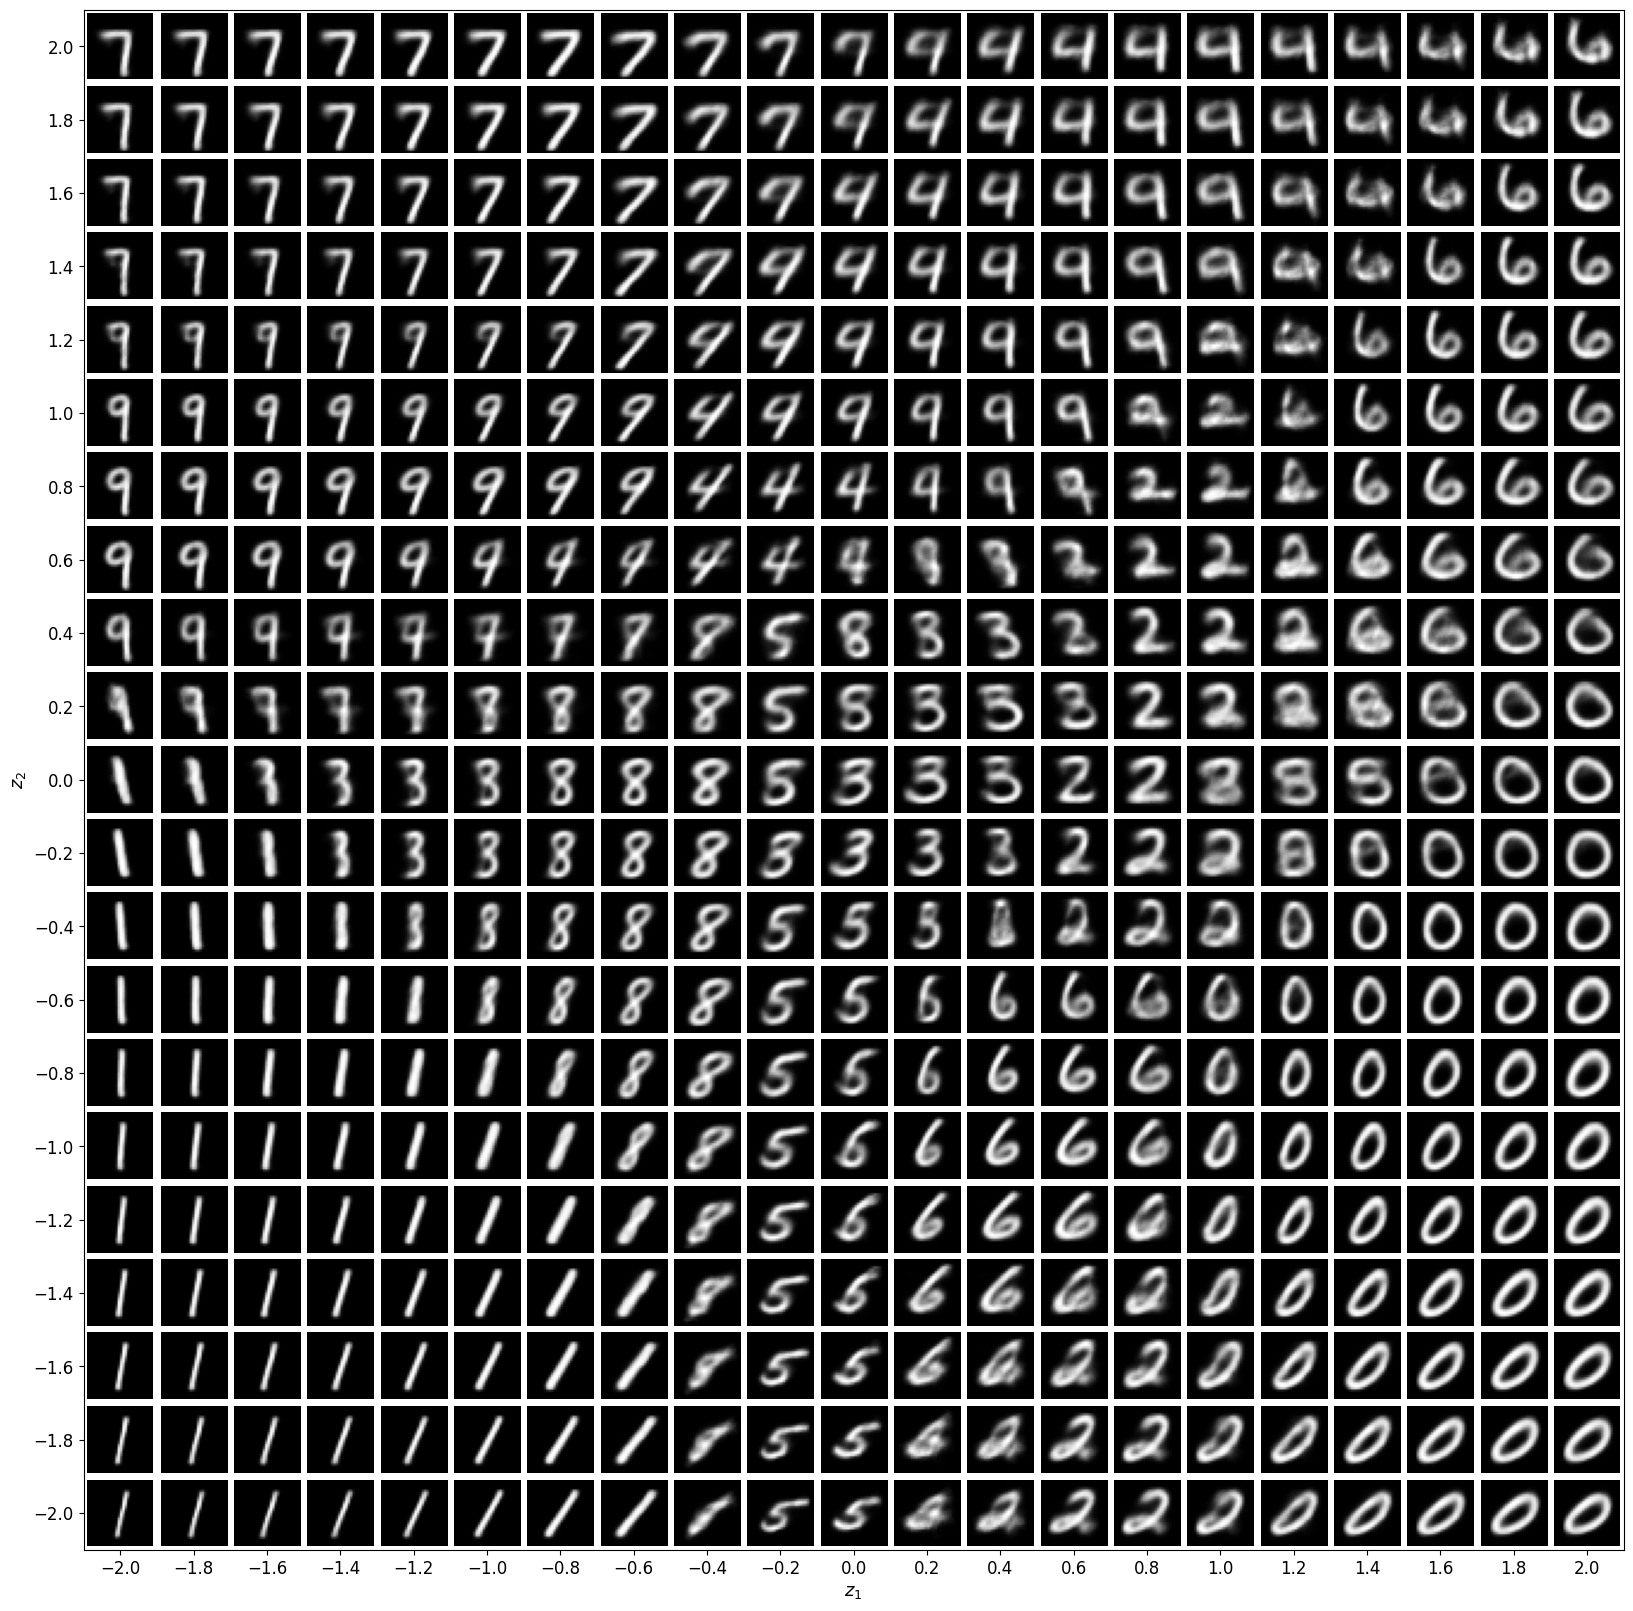

In [13]:
coord_range = torch.arange(-2, 2.2, 0.2)
delta = coord_range[1] - coord_range[0]
img_size = delta - 0.02

fig, ax = plt.subplots(figsize=(20, 20))

for i, x in enumerate(coord_range):
  for j, y in enumerate(coord_range):
    z = np.array([x, y])

    with torch.no_grad():
      rx = model.decoder(
        torch.tensor(z).to(device)
      ).cpu().numpy().reshape(28, 28)

    extent = [
      x - img_size / 2, x + img_size / 2, y - img_size / 2, y + img_size / 2
    ]
    ax.imshow(rx, extent=extent, cmap='gray')

ax.set_xlim([coord_range.min() - delta / 2, coord_range.max() + delta / 2])
ax.set_ylim([coord_range.min() - delta / 2, coord_range.max() + delta / 2])
ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xticks(coord_range)
ax.set_yticks(coord_range)
ax.set_xlabel('$z_1$', fontsize=13)
ax.set_ylabel('$z_2$', fontsize=13)

plt.show()